In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing the data

In [3]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"

# Setup data inputs
IMG_SIZE = (512, 512)

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                shuffle=True,
                                                                                seed=42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis
train_data

Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [4]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

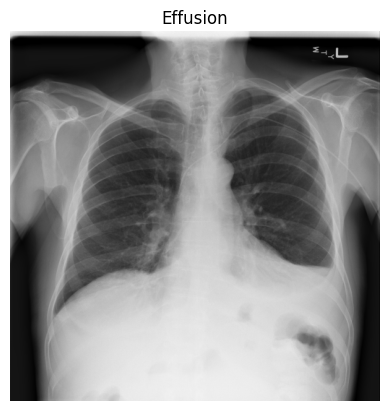

In [5]:
train_one_sample = train_data.take(1) # samples from the training data
for image, label in train_one_sample:
    plt.imshow(image[0]/255.0)
    plt.title(class_names[tf.argmax(label,axis=1)[0].numpy()])
    plt.axis(False)

## Preprocessing the dataset

In [6]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [7]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating the model 

In [10]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(512, 512, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_dense = tf.keras.Model(inputs, outputs)

model_dense.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [11]:
model_dense.fit(
    train_data,
    epochs=5,
    validation_data=valid_data,
    validation_steps=len(valid_data),
)

Epoch 1/5
746/746 [==============================] - 195s 257ms/step - loss: 5568.6826 - accuracy: 0.1734 - val_loss: 894.9742 - val_accuracy: 0.1601
Epoch 2/5
746/746 [==============================] - 190s 252ms/step - loss: 269.8969 - accuracy: 0.1536 - val_loss: 47.7436 - val_accuracy: 0.1522
Epoch 3/5
746/746 [==============================] - 194s 257ms/step - loss: 5.0370 - accuracy: 0.1601 - val_loss: 4.8658 - val_accuracy: 0.1424
Epoch 4/5
746/746 [==============================] - 193s 257ms/step - loss: 13.3583 - accuracy: 0.1448 - val_loss: 1.9465 - val_accuracy: 0.1429
Epoch 5/5
746/746 [==============================] - 193s 257ms/step - loss: 1.9452 - accuracy: 0.1460 - val_loss: 1.9465 - val_accuracy: 0.1429


This model performs really poorly, it basically guesses the outputs. We will try to improve it with a CNN